<div class="alert alert-block alert-danger">
<h1>Bank Customer Churn</h1>
</div>

- Goal is to predict which customers are likely to leave the bank using customer data.

<div class="alert alert-block alert-danger">
<h2>Table of Contents</h2>
</div>

[Importing Libraries](#1.0)<br>
[Loading The Data](#2.0)<br>
[Data Preprocessing](#3.0)<br>
    <ul>
        <li>[Functions to be used](#3.1)</li>
        <li>[Analyze each feature](#3.2)</li>
        <li>[Feature engineerin](#3.3)</li>
        <li>[Correlation of the features](#3.4)</li>
    </ul>
[Machine Learning Algorithms and Results](#4.0)<br>
    <ul>
        <li>[Running machine learning models](#4.1)</li>
        <li>[Model selection - final](#4.2)</li>
        <li>[Evaluation of the selected model](#4.3)</li>
    </ul>

<a id='1.0'></a>
<div class="alert alert-block alert-danger">
<h2>Importing Libraries</h2>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
# # natural images of 10 different classes with 50000 training and 10000 test grayscale 32x32 pixels RGB images
# from tensorflow.keras import Sequential, Input, Model
# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.activations import relu

<a id='2.0'></a>
<div class="alert alert-block alert-danger">
<h2>Loading The Data</h2>
</div>

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<strong>Content</strong><br>
This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.<br>
- CustomerId: Unique Ids for bank customer identification
- Surname: Customer's last name
- CreditScore: Credit score of the customer
- Geography: The country from which the customer belongs
- Gender: Male or Female
- Age: Age of the customer
- Tenure: Number of years for which the customer has been with the bank
- Balance: Bank balance of the customer
- NumOfProducts: Number of bank products the customer is utilising
- HasCrCard: Binary Flag for whether the customer holds a credit card with the bank or not
- IsActiveMember: Binary Flag for whether the customer is an active member with the bank or not
- EstimatedSalary: Estimated salary of the customer in Dollars
- Exited: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained

<div class="alert alert-block alert-success">
    <h4>
        Balanced or imbalanced?
    </h4>
</div>

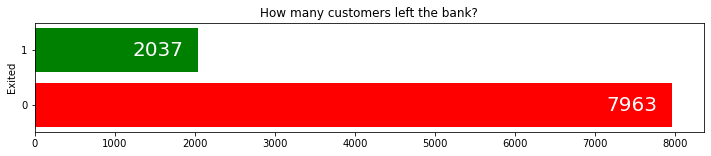

In [3]:
# The difference between positive and negative values in the dependent feature is not very high. 
# So the dataset is in imbalance.

fig, ax = plt.subplots(figsize = (12, 2))
# Horizontal bar chart
ax.barh(df['Exited'].value_counts().index, df['Exited'].value_counts().values, align='center', color=['red', 'green'])
ax.text(df['Exited'].value_counts().values[0]-500, 0, df['Exited'].value_counts()[0], ha='center', va='center', color='w', size=20)
ax.text(df['Exited'].value_counts().values[1]-500, 1, df['Exited'].value_counts()[1], ha='center', va='center', color='w', size=20)
ax.set_yticks(df['Exited'].unique())
ax.set_ylabel('Exited')
ax.set_title('How many customers left the bank?')

plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Check missing values
    </h4>
</div>

In [4]:
def get_null_count(df):
    df_null = pd.DataFrame(df.isnull().sum(), columns=['count'])
    return df_null[df_null['count']>0]

In [5]:
get_null_count(df)

,count


<a id='3.0'></a>
<div class="alert alert-block alert-danger">
<h2>Data Preprocessing</h2>
</div>

<a id='3.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Functions to be used
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Visualizations
    </h4>
</div>

In [6]:
# plot a stacked bar chart to show how a feature is categorized using the independent feature
def stacked_bar_chart(df, col, target_col):
    df_group = df.groupby(col)[target_col].value_counts().sort_index(level=0).unstack()
    print(df_group)
    
    fig, ax = plt.subplots()
    width = 0.35
    
    # place the first category
    x = [str(i) for i in df_group.index]
    y = df_group[0].values
    ax.bar(x, y, width, label=df_group.columns[0])
    
    # add the second category after the previous one
    for i in range(1, len(df_group.columns)):
        z = df_group[i].values
        ax.bar(x, z, width, bottom=y, label=df_group.columns[i])
        y += z
        
    ax.set_ylabel(target_col)
    ax.set_xlabel(col)
    ax.legend()
        
    plt.show()

In [7]:
# plot a histogram chart to show a continuous dataset grouped into bins or frequencies
def hist_chart(df, num_bins):
    fig, axes = plt.subplots()

#     sigma = df.dropna().std() # standard deviation of distribution
#     mu = df.dropna().mean() # mean of distribution
#     x = mu + sigma * np.random.randn(1000)
    
    # the histogram of the data
    n, bins, patches = plt.hist(df, num_bins, density=False, color='green', stacked=True, alpha=0.75)

#     # add a 'best fit' line
#     y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#     plt.plot(bins, y, '--', color ='black')
        
    fig.tight_layout()
    fig.show()

<img src="https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png" style="height:250px">

median (Q2/50th Percentile): the middle value of the dataset<br>
first quartile (Q1/25th Percentile): the middle number between the smallest number (not the “minimum”) and the median of the dataset.<br>
third quartile (Q3/75th Percentile): the middle value between the median and the highest value (not the “maximum”) of the dataset.<br>
interquartile range (IQR): 25th to the 75th percentile.<br>
whiskers (shown in blue)<br>
outliers (shown as green circles)<br>
“maximum”: Q3 + 1.5*IQR<br>
“minimum”: Q1 -1.5*IQR<br>

In [8]:
# plot a boxplot to show how the values in the dataset are spread out
def box_plot(df, label):
    fig, ax = plt.subplots(figsize = (10, 1))
    # rectangular box plot
    bplot = ax.boxplot(df,
                           vert=False,  # vertical box alignment
                           notch=True,  # notch shape
                           patch_artist=True,  # fill with color
                           labels=[label]  # will be used to label x-ticks
                          )
    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for box in (bplot):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)


    whiskers_1 = bplot['whiskers'][0].get_xdata()[1]
    whiskers_2 = bplot['whiskers'][0].get_xdata()[0]
    median = bplot['medians'][0].get_xdata()[0]
    whiskers_3 = bplot['whiskers'][1].get_xdata()[0]
    whiskers_4 = bplot['whiskers'][1].get_xdata()[1]
    
    ax.text(whiskers_1, 1.15, f"{whiskers_1}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_2, 1.25, f"{whiskers_2}", ha='center', va='center', color='b', size=13)
    ax.text(median, 0.7, f"{median}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_3, 1.25, f"{whiskers_3}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_4, 1.15, f"{whiskers_4}", ha='center', va='center', color='b', size=13)

    ax.xaxis.grid(True)
    plt.show()

    outliers = bplot['fliers'][0].get_xdata()

<div class="alert alert-block alert-success">
    <h4>
        Encoding
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [9]:
# One Hot Encoding: Encode categorical features as a one-hot numeric array.
# find the unique values per feature and transform the data to a binary one-hot encoding
from sklearn.preprocessing import OneHotEncoder

def ohe_to_df(df_encoded, ohe_col_name, df_org, ohe_col):
    df_enc = pd.DataFrame(data=df_encoded, columns=ohe_col_name)
    
    # Some rows can be deleted since they are outliers.
    # Therefore, the index numbers are replaced with the existing dataframe
    df_enc.set_index(df_org.index, inplace=True)
    
    # drop the feature to be encoded from the main dataframe and 
    # concatenate the main dataframe with the encoded one
    df_org_dropped = df_org.drop(ohe_col, axis=1)
    df_finished = pd.concat([df_org_dropped, df_enc], axis=1)
    df_finished[ohe_col_name] = df_finished[ohe_col_name].astype(int)
    
    return df_finished
    
# One Hot Encoding the columns.
def one_hot_encoding(train=None, test=None, ohe_col=None):
    train_for_ohe = train[[ohe_col]]
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Fit OneHotEncoder to X, then transform X
    ohe.fit(train_for_ohe)
    train_encoded = ohe.transform(train_for_ohe)

    # create feature names for the created binary columns using the feature name to be encoded and uniques
    ohe_col_name = ohe.get_feature_names([ohe_col]).tolist()
    
    df_train_encoded = ohe_to_df(train_encoded, ohe_col_name, train, ohe_col)
    
    if test:
        test_for_ohe = test[[ohe_col]]
        test_encoded = ohe.transform(test_for_ohe)
        df_test_encoded = ohe_to_df(test_encoded, ohe_col_name, test, ohe_col)

        return df_train_encoded, df_test_encoded
    return df_train_encoded

In [10]:
# Convert each value in a categorical column to a number from 0 to the number of items-1 by encoding 
def encode_categorical_column(df, col):
    # get unique values
    unique_vals = df[col].value_counts(dropna=True).index.to_list()
    
    if df[col].dtypes == 'object':
        # get a counter in the for loop and replace each unique value with the count to encode 
        for i, j in enumerate(unique_vals):
            df[col].replace(j, i, inplace=True)
    return df

<div class="alert alert-block alert-success">
    <h4>
        KBinsDiscretizer
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html?highlight=kbinsdiscretizer#sklearn.preprocessing.KBinsDiscretizer

In [11]:
from sklearn.preprocessing import KBinsDiscretizer

def k_bins_discretizer(df, col_kbd, n_bins, strategy):
    kbd = KBinsDiscretizer(n_bins = n_bins, encode = 'ordinal', strategy = strategy)
    df[col_kbd] = kbd.fit_transform(df[col_kbd].values.reshape(-1,1)).astype('int64')

    return df

<div class="alert alert-block alert-success">
    <h4>
        Standardization (StandardScaler)
    </h4>
</div>

In [12]:
from sklearn.preprocessing import StandardScaler

def standardisation(train=None, test=None, col=None):
    train_for_scaler = train[[col]]
    
    scaler = StandardScaler()
    scaler.fit(train_for_scaler)
    
    # Discretize the data
    train_scaled = scaler.transform(train_for_scaler)
    train[col] = train_scaled
    
    if test:
        test_for_scaler = test[[col]]
        test_scaled = scaler.transform(test_for_scaler)
        test[col] = test_scaled
        return train, test
    return train

<a id='3.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Analyze each feature
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Geography
    </h4>
</div>

Exited        0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413


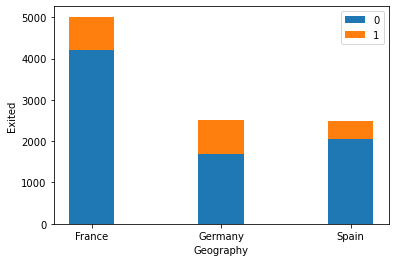

In [13]:
stacked_bar_chart(df, 'Geography', 'Exited')

In [14]:
df.groupby(['Geography', 'Exited']).count()

RowNumber  CustomerId  Surname  CreditScore  Gender   Age  \
Geography Exited                                                              
France    0            4204        4204     4204         4204    4204  4204   
          1             810         810      810          810     810   810   
Germany   0            1695        1695     1695         1695    1695  1695   
          1             814         814      814          814     814   814   
Spain     0            2064        2064     2064         2064    2064  2064   
          1             413         413      413          413     413   413   

                  Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  \
Geography Exited                                                              
France    0         4204     4204           4204       4204            4204   
          1          810      810            810        810             810   
Germany   0         1695     1695           1695       1695            1695   
          1          814      814            814        814             814   
Spain     0         2064     2064           2064       2064            2064   
          1          413      413            413        413             413   

                  EstimatedSalary  
Geography Exited                   
France    0                  4204  
          1                   810  
Germany   0                  1695  
          1                   814  
Spain     0                  2064  
          1                   413

In [15]:
# France
print('{:.1%} of France customers closed their accounts.'.format(810/(4204+810)))
print('=====')
# Germany
print('{:.1%} of German customers closed their accounts.'.format(814/(1695+814)))
print('=====')
# Spain
print('{:.1%} of Spain customers closed their accounts.'.format(413/(2064+413)))


16.2% of France customers closed their accounts.
=====
32.4% of German customers closed their accounts.
=====
16.7% of Spain customers closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [16]:
df = one_hot_encoding(train=df, ohe_col='Geography')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,2,15647311,Hill,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,4,15701354,Boni,699,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,5,15737888,Mitchell,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


<div class="alert alert-block alert-success">
    <h4>
        Gender
    </h4>
</div>

Exited     0     1
Gender            
Female  3404  1139
Male    4559   898


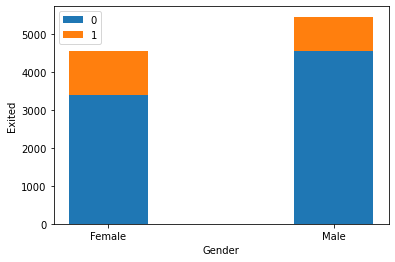

In [17]:
stacked_bar_chart(df, 'Gender', 'Exited')

In [18]:
df.groupby(['Gender', 'Exited']).count()

RowNumber  CustomerId  Surname  CreditScore   Age  Tenure  \
Gender Exited                                                              
Female 0            3404        3404     3404         3404  3404    3404   
       1            1139        1139     1139         1139  1139    1139   
Male   0            4559        4559     4559         4559  4559    4559   
       1             898         898      898          898   898     898   

               Balance  NumOfProducts  HasCrCard  IsActiveMember  \
Gender Exited                                                      
Female 0          3404           3404       3404            3404   
       1          1139           1139       1139            1139   
Male   0          4559           4559       4559            4559   
       1           898            898        898             898   

               EstimatedSalary  Geography_France  Geography_Germany  \
Gender Exited                                                         
Female 0                  3404              3404               3404   
       1                  1139              1139               1139   
Male   0                  4559              4559               4559   
       1                   898               898                898   

               Geography_Spain  
Gender Exited                   
Female 0                  3404  
       1                  1139  
Male   0                  4559  
       1                   898

In [19]:
print('{:.1%} of Female customers closed their accounts.'.format(1139/(3404+1139)))
print('=====')
print('{:.1%} of Male customers closed their accounts.'.format(898/(4559+898)))

25.1% of Female customers closed their accounts.
=====
16.5% of Male customers closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [20]:
df = one_hot_encoding(train=df, ohe_col='Gender')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


<div class="alert alert-block alert-success">
    <h4>
        NumOfProducts
    </h4>
</div>

Exited              0       1
NumOfProducts                
1              3675.0  1409.0
2              4242.0   348.0
3                46.0   220.0
4                 NaN    60.0


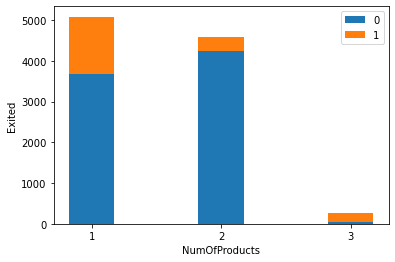

In [21]:
stacked_bar_chart(df, 'NumOfProducts', 'Exited')

In [22]:
df.groupby(['NumOfProducts', 'Exited']).count()

RowNumber  CustomerId  Surname  CreditScore   Age  \
NumOfProducts Exited                                                      
1             0            3675        3675     3675         3675  3675   
              1            1409        1409     1409         1409  1409   
2             0            4242        4242     4242         4242  4242   
              1             348         348      348          348   348   
3             0              46          46       46           46    46   
              1             220         220      220          220   220   
4             1              60          60       60           60    60   

                      Tenure  Balance  HasCrCard  IsActiveMember  \
NumOfProducts Exited                                               
1             0         3675     3675       3675            3675   
              1         1409     1409       1409            1409   
2             0         4242     4242       4242            4242   
              1          348      348        348             348   
3             0           46       46         46              46   
              1          220      220        220             220   
4             1           60       60         60              60   

                      EstimatedSalary  Geography_France  Geography_Germany  \
NumOfProducts Exited                                                         
1             0                  3675              3675               3675   
              1                  1409              1409               1409   
2             0                  4242              4242               4242   
              1                   348               348                348   
3             0                    46                46                 46   
              1                   220               220                220   
4             1                    60                60                 60   

                      Geography_Spain  Gender_Female  Gender_Male  
NumOfProducts Exited                                               
1             0                  3675           3675         3675  
              1                  1409           1409         1409  
2             0                  4242           4242         4242  
              1                   348            348          348  
3             0                    46             46           46  
              1                   220            220          220  
4             1                    60             60           60

In [23]:
print('{:.1%} of customers use 1 of bank products closed their accounts.'.format(1409/(3675+1409)))
print('=====')
print('{:.1%} of customers use 2 of bank products closed their accounts.'.format(348/(4242+348)))
print('=====')
print('{:.1%} of customers use 3 of bank products closed their accounts.'.format(220/(46+220)))
print('=====')
print('{:.1%} of customers use 4 of bank products closed their accounts.'.format(60/(0+60)))

27.7% of customers use 1 of bank products closed their accounts.
=====
7.6% of customers use 2 of bank products closed their accounts.
=====
82.7% of customers use 3 of bank products closed their accounts.
=====
100.0% of customers use 4 of bank products closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [24]:
df = one_hot_encoding(train=df, ohe_col='NumOfProducts')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,1,15634602,Hargrave,619,42,2,0.00,1,1,101348.88,1,1,0,0,1,0,1,0,0,0
1,2,15647311,Hill,608,41,1,83807.86,0,1,112542.58,0,0,0,1,1,0,1,0,0,0
2,3,15619304,Onio,502,42,8,159660.80,1,0,113931.57,1,1,0,0,1,0,0,0,1,0
3,4,15701354,Boni,699,39,1,0.00,0,0,93826.63,0,1,0,0,1,0,0,1,0,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,79084.10,0,0,0,1,1,0,1,0,0,0


<div class="alert alert-block alert-success">
    <h4>
        HasCrCard
    </h4>
</div>

Exited        0     1
HasCrCard            
0          2332   613
1          5631  1424


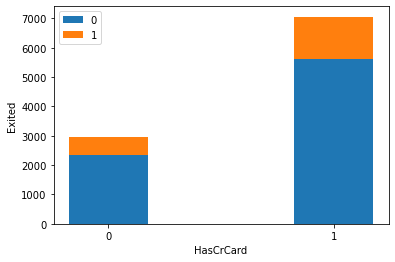

In [25]:
stacked_bar_chart(df, 'HasCrCard', 'Exited')

In [26]:
df.groupby(['HasCrCard', 'Exited']).count()

RowNumber  CustomerId  Surname  CreditScore   Age  Tenure  \
HasCrCard Exited                                                              
0         0            2332        2332     2332         2332  2332    2332   
          1             613         613      613          613   613     613   
1         0            5631        5631     5631         5631  5631    5631   
          1            1424        1424     1424         1424  1424    1424   

                  Balance  IsActiveMember  EstimatedSalary  Geography_France  \
HasCrCard Exited                                                               
0         0          2332            2332             2332              2332   
          1           613             613              613               613   
1         0          5631            5631             5631              5631   
          1          1424            1424             1424              1424   

                  Geography_Germany  Geography_Spain  Gender_Female  \
HasCrCard Exited                                                      
0         0                    2332             2332           2332   
          1                     613              613            613   
1         0                    5631             5631           5631   
          1                    1424             1424           1424   

                  Gender_Male  NumOfProducts_1  NumOfProducts_2  \
HasCrCard Exited                                                  
0         0              2332             2332             2332   
          1               613              613              613   
1         0              5631             5631             5631   
          1              1424             1424             1424   

                  NumOfProducts_3  NumOfProducts_4  
HasCrCard Exited                                    
0         0                  2332             2332  
          1                   613              613  
1         0                  5631             5631  
          1                  1424             1424

In [27]:
print('{:.1%} of customers does not have a credit card closed their accounts.'.format(613/(2332+613)))
print('=====')
print('{:.1%} of customers have a credit card closed their accounts.'.format(1424/(5631+1424)))

20.8% of customers does not have a credit card closed their accounts.
=====
20.2% of customers have a credit card closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [28]:
df = one_hot_encoding(train=df, ohe_col='HasCrCard')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,IsActiveMember,EstimatedSalary,Exited,...,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1
0,1,15634602,Hargrave,619,42,2,0.00,1,101348.88,1,...,0,0,1,0,1,0,0,0,0,1
1,2,15647311,Hill,608,41,1,83807.86,1,112542.58,0,...,0,1,1,0,1,0,0,0,1,0
2,3,15619304,Onio,502,42,8,159660.80,0,113931.57,1,...,0,0,1,0,0,0,1,0,0,1
3,4,15701354,Boni,699,39,1,0.00,0,93826.63,0,...,0,0,1,0,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,79084.10,0,...,0,1,1,0,1,0,0,0,0,1


<div class="alert alert-block alert-success">
    <h4>
        IsActiveMember
    </h4>
</div>

Exited             0     1
IsActiveMember            
0               3547  1302
1               4416   735


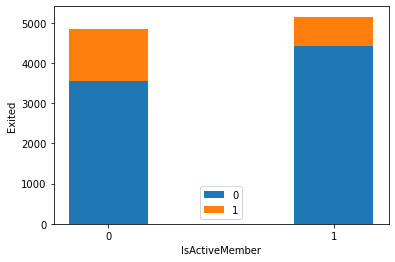

In [29]:
stacked_bar_chart(df, 'IsActiveMember', 'Exited')

In [30]:
df.groupby(['IsActiveMember', 'Exited']).count()

RowNumber  CustomerId  Surname  CreditScore   Age  \
IsActiveMember Exited                                                      
0              0            3547        3547     3547         3547  3547   
               1            1302        1302     1302         1302  1302   
1              0            4416        4416     4416         4416  4416   
               1             735         735      735          735   735   

                       Tenure  Balance  EstimatedSalary  Geography_France  \
IsActiveMember Exited                                                       
0              0         3547     3547             3547              3547   
               1         1302     1302             1302              1302   
1              0         4416     4416             4416              4416   
               1          735      735              735               735   

                       Geography_Germany  Geography_Spain  Gender_Female  \
IsActiveMember Exited                                                      
0              0                    3547             3547           3547   
               1                    1302             1302           1302   
1              0                    4416             4416           4416   
               1                     735              735            735   

                       Gender_Male  NumOfProducts_1  NumOfProducts_2  \
IsActiveMember Exited                                                  
0              0              3547             3547             3547   
               1              1302             1302             1302   
1              0              4416             4416             4416   
               1               735              735              735   

                       NumOfProducts_3  NumOfProducts_4  HasCrCard_0  \
IsActiveMember Exited                                                  
0              0                  3547             3547         3547   
               1                  1302             1302         1302   
1              0                  4416             4416         4416   
               1                   735              735          735   

                       HasCrCard_1  
IsActiveMember Exited               
0              0              3547  
               1              1302  
1              0              4416  
               1               735

In [31]:
print('{:.1%} of customers who are not active their accounts.'.format(1302/(3547+1302)))
print('=====')
print('{:.1%} of customers who are active closed their accounts.'.format(735/(4416+735)))

26.9% of customers who are not active their accounts.
=====
14.3% of customers who are active closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [32]:
df = one_hot_encoding(train=df, ohe_col='IsActiveMember')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,...,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,1,15634602,Hargrave,619,42,2,0.00,101348.88,1,1,...,1,0,1,0,0,0,0,1,0,1
1,2,15647311,Hill,608,41,1,83807.86,112542.58,0,0,...,1,0,1,0,0,0,1,0,0,1
2,3,15619304,Onio,502,42,8,159660.80,113931.57,1,1,...,1,0,0,0,1,0,0,1,1,0
3,4,15701354,Boni,699,39,1,0.00,93826.63,0,1,...,1,0,0,1,0,0,1,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,79084.10,0,0,...,1,0,1,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        Age
    </h4>
</div>

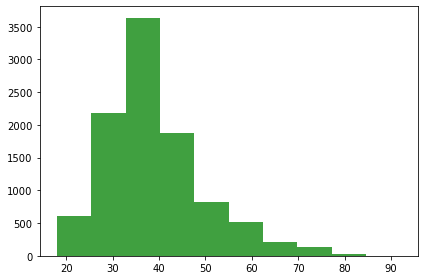

In [33]:
hist_chart(df['Age'], 10)

<div class="alert alert-block alert-warning">
        Drop Outliers
</div>

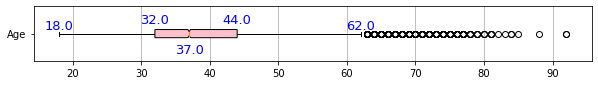

In [34]:
box_plot(df['Age'], 'Age')

In [35]:
outliers_index_age = df[df['Age'] > 80].index
print(outliers_index_age)

Int64Index([766, 2458, 3033, 3387, 3531, 4931, 6443, 6759, 7526, 7956, 9080,
            9309],
           dtype='int64')


In [36]:
df = df.drop(outliers_index_age, axis=0).reset_index(drop=True)

<div class="alert alert-block alert-warning">
        Standardisation
</div>

In [37]:
df= standardisation(train=df, col='Age')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,...,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,1,15634602,Hargrave,619,0.302032,2,0.00,101348.88,1,1,...,1,0,1,0,0,0,0,1,0,1
1,2,15647311,Hill,608,0.205627,1,83807.86,112542.58,0,0,...,1,0,1,0,0,0,1,0,0,1
2,3,15619304,Onio,502,0.302032,8,159660.80,113931.57,1,1,...,1,0,0,0,1,0,0,1,1,0
3,4,15701354,Boni,699,0.012818,1,0.00,93826.63,0,1,...,1,0,0,1,0,0,1,0,1,0
4,5,15737888,Mitchell,850,0.398436,2,125510.82,79084.10,0,0,...,1,0,1,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        Balance
    </h4>
</div>

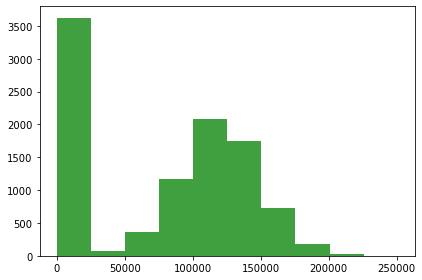

In [38]:
hist_chart(df['Balance'], 10)

<div class="alert alert-block alert-warning">
        Drop Outliers
</div>

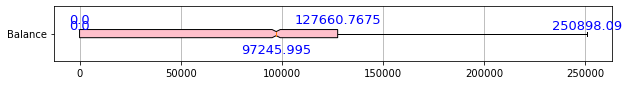

In [39]:
box_plot(df['Balance'], 'Balance')

<div class="alert alert-block alert-warning">
        Standardisation
</div>

In [40]:
df= standardisation(train=df, col='Balance')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,...,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,1,15634602,Hargrave,619,0.302032,2,-1.226201,101348.88,1,1,...,1,0,1,0,0,0,0,1,0,1
1,2,15647311,Hill,608,0.205627,1,0.116954,112542.58,0,0,...,1,0,1,0,0,0,1,0,0,1
2,3,15619304,Onio,502,0.302032,8,1.332618,113931.57,1,1,...,1,0,0,0,1,0,0,1,1,0
3,4,15701354,Boni,699,0.012818,1,-1.226201,93826.63,0,1,...,1,0,0,1,0,0,1,0,1,0
4,5,15737888,Mitchell,850,0.398436,2,0.785310,79084.10,0,0,...,1,0,1,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        EstimatedSalary
    </h4>
</div>

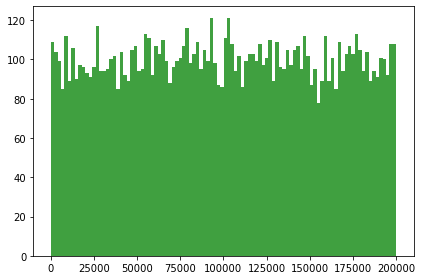

In [41]:
hist_chart(df['EstimatedSalary'], 100)

<div class="alert alert-block alert-warning">
        Drop Outliers
</div>

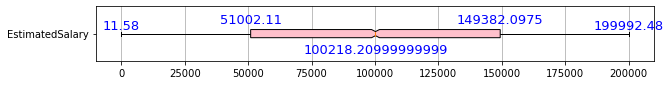

In [42]:
box_plot(df['EstimatedSalary'], 'EstimatedSalary')

<div class="alert alert-block alert-warning">
        Standardisation
</div>

In [43]:
df= standardisation(train=df, col='EstimatedSalary')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,...,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,1,15634602,Hargrave,619,0.302032,2,-1.226201,0.022020,1,1,...,1,0,1,0,0,0,0,1,0,1
1,2,15647311,Hill,608,0.205627,1,0.116954,0.216685,0,0,...,1,0,1,0,0,0,1,0,0,1
2,3,15619304,Onio,502,0.302032,8,1.332618,0.240841,1,1,...,1,0,0,0,1,0,0,1,1,0
3,4,15701354,Boni,699,0.012818,1,-1.226201,-0.108796,0,1,...,1,0,0,1,0,0,1,0,1,0
4,5,15737888,Mitchell,850,0.398436,2,0.785310,-0.365178,0,0,...,1,0,1,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        CreditScore
    </h4>
</div>

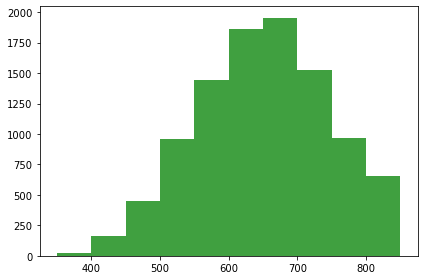

In [44]:
hist_chart(df['CreditScore'], 10)

<p style="background-color:#FCF3CF; font-family:'San Francisco'; font-size:14px; text-align:left; padding: 0.6em; border-radius: 5px 5px">Drop Outliers</p>

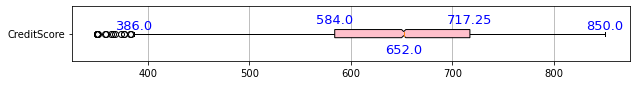

In [45]:
box_plot(df['CreditScore'], 'CreditScore')

In [46]:
outliers_index_age = df[df['CreditScore'] < 380].index
print(outliers_index_age)

Int64Index([7, 941, 1192, 1404, 1630, 1837, 1961, 2471, 2577, 8144, 8713, 8752,
            9344, 9612],
           dtype='int64')


In [47]:
df = df.drop(outliers_index_age, axis=0).reset_index(drop=True)

<div class="alert alert-block alert-warning">
        Standardisation
</div>

In [48]:
df= standardisation(train=df, col='CreditScore')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,...,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,1,15634602,Hargrave,-0.332123,0.302032,2,-1.226201,0.022020,1,1,...,1,0,1,0,0,0,0,1,0,1
1,2,15647311,Hill,-0.446648,0.205627,1,0.116954,0.216685,0,0,...,1,0,1,0,0,0,1,0,0,1
2,3,15619304,Onio,-1.550256,0.302032,8,1.332618,0.240841,1,1,...,1,0,0,0,1,0,0,1,1,0
3,4,15701354,Boni,0.500789,0.012818,1,-1.226201,-0.108796,0,1,...,1,0,0,1,0,0,1,0,1,0
4,5,15737888,Mitchell,2.072909,0.398436,2,0.785310,-0.365178,0,0,...,1,0,1,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        Tenure
    </h4>
</div>

Exited    0    1
Tenure          
0       318   92
1       801  231
2       846  201
3       795  212
4       786  201
5       802  209
6       768  192
7       851  176
8       827  195
9       771  213
10      387  100


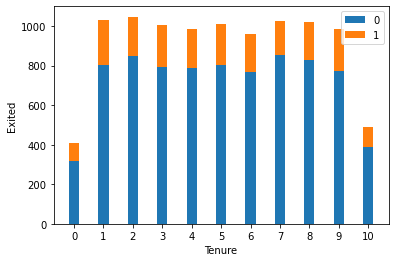

In [49]:
stacked_bar_chart(df, 'Tenure', 'Exited')

<div class="alert alert-block alert-success">
    <h4>
        CustomerId
    </h4>
</div>

In [50]:
customerId_category = []
for i in df['CustomerId']:
    customerId_category.append(str(i)[:3])
df['customerId_category'] = customerId_category
df.drop(['CustomerId'], axis=1, inplace=True)

Exited                  0    1
customerId_category           
155                  1054  292
156                  3208  802
157                  3200  798
158                   490  130


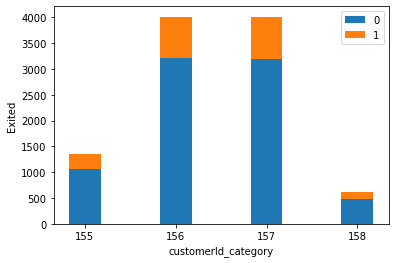

In [51]:
stacked_bar_chart(df, 'customerId_category', 'Exited')

In [52]:
df.groupby(['customerId_category', 'Exited']).count()

RowNumber  Surname  CreditScore   Age  Tenure  \
customerId_category Exited                                                  
155                 0            1054     1054         1054  1054    1054   
                    1             292      292          292   292     292   
156                 0            3208     3208         3208  3208    3208   
                    1             802      802          802   802     802   
157                 0            3200     3200         3200  3200    3200   
                    1             798      798          798   798     798   
158                 0             490      490          490   490     490   
                    1             130      130          130   130     130   

                            Balance  EstimatedSalary  Geography_France  \
customerId_category Exited                                               
155                 0          1054             1054              1054   
                    1           292              292               292   
156                 0          3208             3208              3208   
                    1           802              802               802   
157                 0          3200             3200              3200   
                    1           798              798               798   
158                 0           490              490               490   
                    1           130              130               130   

                            Geography_Germany  Geography_Spain  Gender_Female  \
customerId_category Exited                                                      
155                 0                    1054             1054           1054   
                    1                     292              292            292   
156                 0                    3208             3208           3208   
                    1                     802              802            802   
157                 0                    3200             3200           3200   
                    1                     798              798            798   
158                 0                     490              490            490   
                    1                     130              130            130   

                            Gender_Male  NumOfProducts_1  NumOfProducts_2  \
customerId_category Exited                                                  
155                 0              1054             1054             1054   
                    1               292              292              292   
156                 0              3208             3208             3208   
                    1               802              802              802   
157                 0              3200             3200             3200   
                    1               798              798              798   
158                 0               490              490              490   
                    1               130              130              130   

                            NumOfProducts_3  NumOfProducts_4  HasCrCard_0  \
customerId_category Exited                                                  
155                 0                  1054             1054         1054   
                    1                   292              292          292   
156                 0                  3208             3208         3208   
                    1                   802              802          802   
157                 0                  3200             3200         3200   
                    1                   798              798          798   
158                 0                   490              490          490   
                    1                   130              130          130   

                            HasCrCard_1  IsActiveMember_0  IsActiveMember_1  
customerId_category Exited                                                   
155    

In [53]:
print('{:.1%} of customers with 155 ID closed their accounts.'.format(292/(1054+292)))
print('=====')
print('{:.1%} of customers with 156 ID closed their accounts.'.format(802/(3208+802)))
print('=====')
print('{:.1%} of customers with 157 ID closed their accounts.'.format(798/(3200+798)))
print('=====')
print('{:.1%} of customers with 158 ID closed their accounts.'.format(130/(490+130)))

21.7% of customers with 155 ID closed their accounts.
=====
20.0% of customers with 156 ID closed their accounts.
=====
20.0% of customers with 157 ID closed their accounts.
=====
21.0% of customers with 158 ID closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [54]:
df = one_hot_encoding(train=df, ohe_col='customerId_category')
df.head()

,RowNumber,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,Geography_Germany,...,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,customerId_category_155,customerId_category_156,customerId_category_157,customerId_category_158
0,1,Hargrave,-0.332123,0.302032,2,-1.226201,0.022020,1,1,0,...,0,0,0,1,0,1,0,1,0,0
1,2,Hill,-0.446648,0.205627,1,0.116954,0.216685,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,3,Onio,-1.550256,0.302032,8,1.332618,0.240841,1,1,0,...,1,0,0,1,1,0,0,1,0,0
3,4,Boni,0.500789,0.012818,1,-1.226201,-0.108796,0,1,0,...,0,0,1,0,1,0,0,0,1,0
4,5,Mitchell,2.072909,0.398436,2,0.785310,-0.365178,0,0,0,...,0,0,0,1,0,1,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Drop features
    </h4>
</div>

In [55]:
df = df.drop(['RowNumber', 'Surname'], axis=1)

<a id='3.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Feature Engineering
   </h3>
</div>

In [56]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.20, random_state=0)

print(X_train.shape)
print(X_test.shape)

(7979, 22)
(1995, 22)


<div class="alert alert-block alert-success">
    <h4>
        Check categorical columns
    </h4>
</div>

In [58]:
categorical_feature_cols = list(set(X_train.columns) - set(X_train._get_numeric_data().columns))
categorical_feature_cols

[]

- There is no categorical columns in the dataframe

In [59]:
numerical_feature_cols = list(X_train._get_numeric_data().columns)
print(numerical_feature_cols)

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'HasCrCard_0', 'HasCrCard_1', 'IsActiveMember_0', 'IsActiveMember_1', 'customerId_category_155', 'customerId_category_156', 'customerId_category_157', 'customerId_category_158']


<div class="alert alert-block alert-success">
    <h4>
        Constant and quasi constant features removal
    </h4>
</div>

- Constant: remove the features that have the same value in all samples
- Quasi constant : remove the features that they have the 99% same value

In [60]:
# Constant
from sklearn.feature_selection import VarianceThreshold
constant=VarianceThreshold(threshold=0)
constant.fit(X_train)

constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant.get_support()]]
print(len(constant_columns))

0


In [61]:
# Quasi constant
from sklearn.feature_selection import VarianceThreshold
quasi_constant=VarianceThreshold(threshold=0.01)
quasi_constant.fit(X_train)

quasi_constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[quasi_constant.get_support()]]
print(quasi_constant_columns)

['NumOfProducts_4']


In [62]:
X_train = pd.DataFrame(quasi_constant.transform(X_train), columns=X_train.columns[quasi_constant.get_support()])
X_test = pd.DataFrame(quasi_constant.transform(X_test), columns=X_test.columns[quasi_constant.get_support()])

In [63]:
X_train.shape, X_test.shape

((7979, 21), (1995, 21))

<div class="alert alert-block alert-success">
    <h4>
        Remove duplicate features
    </h4>
</div>

In [64]:
X_train_T = X_train.T
X_test_T = X_test.T

In [65]:
X_train_T.duplicated().sum()

0

- There are no dublicated features

In [66]:
# features_to_keep = [not ind for ind  in X_train_T.duplicated()]
# X_train = X_train_T[features_to_keep].T
# X_test = X_test_T[features_to_keep].T

<div class="alert alert-block alert-success">
    <h4>
        Drop highly correlated features using Pearson Correlation
    </h4>
</div>

In [67]:
def highly_correlated_features(df, threshold):
    corr_matrix = df.corr()
    
    df_corr_list = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                ind_name = corr_matrix.columns[i]
                col_name = corr_matrix.columns[j]
                coeff_value_absolute = abs(corr_matrix.iloc[i, j])
                df_corr_list.append([ind_name, col_name, coeff_value_absolute])
                
    df_corr = pd.DataFrame(df_corr_list, columns=['Feature_1', 'Feature_2', 'Corr_value'])
    
    return df_corr
        
df_hcf = highly_correlated_features(df, 0.85)
df_hcf = df_hcf.sort_values(by=['Feature_1', 'Feature_2', 'Corr_value'], ascending=False)
df_hcf

,Feature_1,Feature_2,Corr_value
1,NumOfProducts_2,NumOfProducts_1,0.937118
3,IsActiveMember_1,IsActiveMember_0,1.000000
2,HasCrCard_1,HasCrCard_0,1.000000
0,Gender_Male,Gender_Female,1.000000


<div class="alert alert-block alert-success">
    <h4>
        Feature importance based on RandomForestClassifier
    </h4>
</div>

- create correlated feature groups using the highly_correlated_features dataframe (df_hcf)
- only one feature will be selected from each group using RandomForestClassifier
- other features in each group will be removed

In [68]:
from sklearn.ensemble import RandomForestClassifier

# the list is used to check if each feature is in previous groups
grouped_feature_list = []
# the items in the list will be removed from the X_train and X_test
dropped_feature_list = []

for feature in df_hcf['Feature_1'].unique():
    if feature not in grouped_feature_list:
        # group the highly_correlated_features dataframe (df_hcf)
        df_feature = df_hcf[df_hcf['Feature_1'] == feature]        
        
        correlated_features_list = [feature] + list(df_feature['Feature_2'].unique())
        grouped_feature_list = grouped_feature_list + correlated_features_list

        rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
        rf.fit(df[correlated_features_list], y)
        # create an importance dataframe using the feature_importances_ values
        df_importance = pd.concat([pd.Series(correlated_features_list), pd.Series(rf.feature_importances_)], 
                               axis=1)
        df_importance.columns = ['Feature', 'Importance']
        df_importance.sort_values(by = 'Importance', ascending=False, inplace=True)
        # get the feature names except the one that has the highest improtance from the df_importance
        dropped_feature_list = dropped_feature_list + list(df_importance['Feature'][1:].values)
    
print(dropped_feature_list)  


['NumOfProducts_1', 'IsActiveMember_1', 'HasCrCard_1', 'Gender_Male']


In [69]:
# drop the highly correlated features 
X_train = X_train.drop(dropped_feature_list, axis=1)
X_test = X_test.drop(dropped_feature_list, axis=1)

print(X_train.shape)
print(X_test.shape)

(7979, 17)
(1995, 17)


<div class="alert alert-block alert-success">
    <h4>
        SelectFromModel using Logistic Regression
    </h4>
</div>

In [70]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def feature_selection(model, X_train, y_train):
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    acc = cvs.mean()
    
    return acc

In [71]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1)
sfm = SFM(model).fit(X_train, y_train)
cols_SFM = X_train.columns[sfm.get_support()].tolist()
print(cols_SFM)

acc = feature_selection(model, X_train, y_train)
acc_SFM = feature_selection(model, X_train[cols_SFM], y_train)

print('The Accuracy all features: {:.1%}'.format(acc))
print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))

['Age', 'Geography_Germany', 'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3', 'IsActiveMember_0']
The Accuracy all features: 83.9%
The Accuracy selected features with SFM: 83.8%


<div class="alert alert-block alert-success">
    <h4>
        GenericUnivariateSelect and ANOVA F-value
    </h4>
</div>

In [72]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

def best_features (model, X_train, y_train, cols_sel, cols_SFM, acc, acc_SFM):
    cols_model_best = []
    acc_model_best = 0
    for col in cols_sel:
        if col not in cols_SFM:
            cols_SFM = cols_SFM + [col]
            cv = KFold(n_splits=10, random_state=0, shuffle=True)
            cvs_model = cross_val_score(model, X_train[cols_SFM], y_train, scoring='accuracy', cv=cv)
            acc_model = cvs_model.mean()
            if (acc_model > acc_SFM) & (acc_model > acc_model_best):
                cols_model_best = cols_SFM
                acc_model_best = acc_model
                print(cols_model_best)
                print('The Accuracy all features: {:.1%}'.format(acc))
                print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
                print('The Accuracy selected features with MODEL: {:.1%}'.format(acc_model_best))
                print('=====')

In [73]:
from sklearn.feature_selection import GenericUnivariateSelect as GUS
# ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import f_classif

gus_f = GUS(f_classif, mode='k_best', param=len(X_train.columns)).fit(X_train, y_train)
cols_gus_f = X_train.columns[gus_f.get_support()].tolist()

best_features(model, X_train, y_train, cols_gus_f, cols_SFM, acc, acc_SFM)

['Age', 'Geography_Germany', 'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3', 'IsActiveMember_0', 'CreditScore', 'Tenure']
The Accuracy all features: 83.9%
The Accuracy selected features with SFM: 83.8%
The Accuracy selected features with MODEL: 84.0%
=====
['Age', 'Geography_Germany', 'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3', 'IsActiveMember_0', 'CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Geography_France', 'Geography_Spain', 'HasCrCard_0']
The Accuracy all features: 83.9%
The Accuracy selected features with SFM: 83.8%
The Accuracy selected features with MODEL: 84.0%
=====


<div class="alert alert-block alert-success">
    <h4>
        SelectKBest and Mutual Information
    </h4>
</div>

In [74]:
from sklearn.feature_selection import SelectKBest
# Mutual information for a discrete target.
from sklearn.feature_selection import mutual_info_classif

# select the  top k important features
KBest_m = SelectKBest(mutual_info_classif, k=len(X_train.columns)).fit(X_train, y_train)
cols_KBest_m = X_train.columns[KBest_m.get_support()].tolist()

best_features(model, X_train, y_train, cols_KBest_m, cols_SFM, acc, acc_SFM)

['Age', 'Geography_Germany', 'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3', 'IsActiveMember_0', 'CreditScore', 'Tenure']
The Accuracy all features: 83.9%
The Accuracy selected features with SFM: 83.8%
The Accuracy selected features with MODEL: 84.0%
=====
['Age', 'Geography_Germany', 'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3', 'IsActiveMember_0', 'CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Geography_France', 'Geography_Spain', 'HasCrCard_0']
The Accuracy all features: 83.9%
The Accuracy selected features with SFM: 83.8%
The Accuracy selected features with MODEL: 84.0%
=====


<div class="alert alert-block alert-success">
    <h4>
        RFE (Recursive feature elimination)
    </h4>
</div>

In [75]:
from sklearn.feature_selection import RFE

new_cols_RFE = cols_SFM.copy()
acc_RFE_best = 0
new_cols_RFE_best = []

for i in range(10, len(X_train.columns)+1):
    selector = RFE(estimator=model, n_features_to_select=i).fit(X_train, y_train)
    new_cols_RFE = X_train.columns[selector.get_support()]
    
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs_RFE = cross_val_score(model, X_train[new_cols_RFE], y_train, scoring='accuracy', cv=cv)
    acc_RFE = cvs_RFE.mean()
    
    if acc_RFE > acc_RFE_best:
        acc_RFE_best = acc_RFE
        new_cols_RFE_best = new_cols_RFE
        
        print(new_cols_RFE_best)
        print('The Accuracy all features: {:.1%}'.format(acc))
        print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
        print('The Accuracy selected features with KBest: {:.1%}'.format(acc_RFE_best))
        print('=====')

Index(['Age', 'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3', 'HasCrCard_0',
       'IsActiveMember_0', 'customerId_category_158'],
      dtype='object')
The Accuracy all features: 83.9%
The Accuracy selected features with SFM: 83.8%
The Accuracy selected features with KBest: 83.8%
=====
Index(['CreditScore', 'Age', 'Balance', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female',
       'NumOfProducts_2', 'NumOfProducts_3', 'HasCrCard_0', 'IsActiveMember_0',
       'customerId_category_155', 'customerId_category_158'],
      dtype='object')
The Accuracy all features: 83.9%
The Accuracy selected features with SFM: 83.8%
The Accuracy selected features with KBest: 83.9%
=====
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female',
       'NumOfProducts_2', 'NumOfProducts_3', 'HasCrCard_0', 'IsActiveMember_0',


<a id='3.4'></a>
<div class="alert alert-block alert-info">
   <h3>
        Correlation of the features
   </h3>
</div>

In [76]:
selected_features = ['Age', 'Geography_Germany', 'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3', 
                     'IsActiveMember_0', 'CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 
                     'Geography_France', 'Geography_Spain', 'HasCrCard_0']
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(X_train.shape)
print(X_test.shape)

(7979, 13)
(1995, 13)


In [77]:
def create_heatmap(hm, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(hm.columns)))
    ax.set_yticks(np.arange(len(hm.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(hm.columns)
    ax.set_yticklabels(hm.columns)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(hm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(hm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(hm.columns)):
        for j in range(len(hm.columns)):
            hm_val = round(hm.values[i, j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

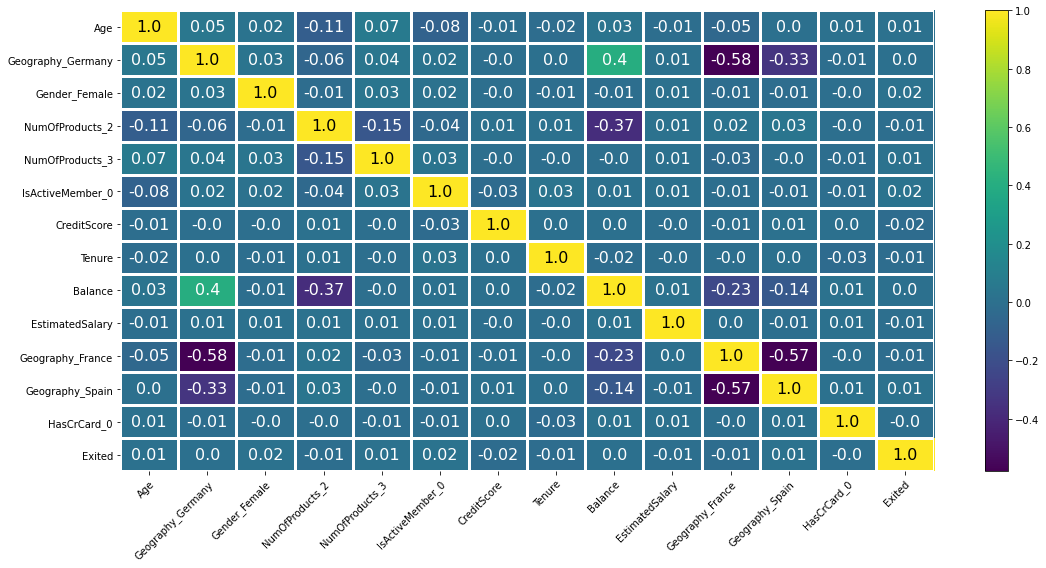

In [78]:
hm_train_new = pd.concat([X_train, y_train], axis=1).corr()
create_heatmap(hm_train_new)

<a id='4.0'></a>
<div class="alert alert-block alert-danger">
<h2>Machine Learning Algorithms and Results</h2>
</div>

In [88]:
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    # We will run the model with 10 different sets and we will get 10 results
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    # Applying Cross Validation to solve possible overfitting problem
    accuracy_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    kFold_accuracy_mean = round(accuracy_scores.mean()*100, 2)
    kFold_accuracy_std = round(accuracy_scores.std()*100, 2)
    
    roc = round(roc_auc_score(y_test, y_pred)*100, 2)
    precision = round(precision_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred)*100, 2)
    f1 = round(f1_score(y_test, y_pred)*100, 2)
    
    print('Accuracy: {}%'.format(accuracy))
    print('KFold Accuracy Mean: {}%'.format(kFold_accuracy_mean))
    print('Standard Deviation: {:.3}'.format(kFold_accuracy_std))
    
    print('ROC Score: {}%'.format(roc))
    print('Precision: {}%'.format(precision))
    print('Recall: {}%'.format(recall))
    print('F1 Score: {}%'.format(f1))

    return accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Overcoming Class Imbalance using SMOTE
   </h3>
</div>

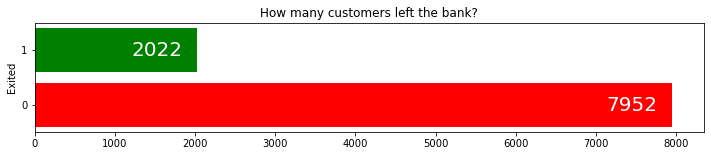

In [79]:
fig, ax = plt.subplots(figsize = (12, 2))
# Horizontal bar chart
ax.barh(y.value_counts().index, y.value_counts().values, align='center', color=['red', 'green'])
ax.text(y.value_counts().values[0]-500, 0, y.value_counts()[0], ha='center', va='center', color='w', size=20)
ax.text(y.value_counts().values[1]-500, 1, y.value_counts()[1], ha='center', va='center', color='w', size=20)
ax.set_yticks(y.unique())
ax.set_ylabel('Exited')
ax.set_title('How many customers left the bank?')

plt.show()

- It is an imbalanced data where the target variable, churn has 79.7% customers not churning and 20.3% customers who have churned
- SMOTE: Synthetic Minority Oversampling Technique will be used for creating synthesized data
- A comparative analysis will be done on the dataset using RandomForestClassifier
- The accuracy metric will be ignored to evaluate the performance of the classifier on this imbalanced dataset
- Precision, recall, F1-score metrics will be taken into account 

<div class="alert alert-block alert-success">
    <h4>
        SMOTE: Synthetic Minority Oversampling Technique
    </h4>
</div>

In [80]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

- SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
- Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

<img src="https://editor.analyticsvidhya.com/uploads/64068image3.png" style="height:250px">

In [85]:
y.value_counts()

0    7952
1    2022
Name: Exited, dtype: int64

In [84]:
y_sm.value_counts()

1    7952
0    7952
Name: Exited, dtype: int64

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, 
                                                                stratify=y_sm)

rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

<div class="alert alert-block alert-warning">
        Before
</div>

In [94]:
evaluate_model(rf, X_train, y_train, X_test, y_test)

Accuracy: 84.71%
KFold Accuracy Mean: 86.26%
Standard Deviation: 1.19
ROC Score: 69.98%
Precision: 76.1%
Recall: 43.81%
F1 Score: 55.6%


(84.71, 86.26, 1.19, 69.98, 76.1, 43.81, 55.6)

<div class="alert alert-block alert-warning">
        After
</div>

In [95]:
evaluate_model(rf, X_train_sm, y_train_sm, X_test_sm, y_test_sm)

Accuracy: 90.63%
KFold Accuracy Mean: 90.48%
Standard Deviation: 0.58
ROC Score: 90.63%
Precision: 90.73%
Recall: 90.5%
F1 Score: 90.62%


(90.63, 90.48, 0.58, 90.63, 90.73, 90.5, 90.62)

- There is an increase in all metrics, especially in Recall

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building ML models
   </h3>
</div>

In [99]:
model_results = {}

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, 
                                                                stratify=y_sm)

<div class="alert alert-block alert-success">
    <h4>
        Logistic
    </h4>
</div>

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png" style="height:150px">

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty='none', max_iter=50, multi_class='auto')
# params = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [i for i in np.arange(0, 20, 1)],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter': [50, 75, 100, 150, 200],
#     'multi_class': ['auto', 'ovr', 'multinomial'],
#          }
# clf_log = GridSearchCV(estimator=log, cv=10, scoring='accuracy', param_grid=params, 
#                        n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_log.best_params_)
# acc_log = clf_log.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_log))

In [100]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(log, X_train, y_train, X_test, y_test)
model_results['log'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')

Accuracy: 86.42%
KFold Accuracy Mean: 85.91%
Standard Deviation: 0.63
ROC Score: 86.42%
Precision: 89.07%
Recall: 83.02%
F1 Score: 85.94%
===
CPU times: user 433 ms, sys: 388 ms, total: 822 ms
Wall time: 322 ms


<div class="alert alert-block alert-success">
    <h4>
        Random Forest
    </h4>
</div>

<img src="https://406167-1278791-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2021/02/Random-Forest-Algorithm-1024x576.jpg" style="height:250px">

In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=125, criterion='gini', max_depth=15, 
                            min_samples_split=10, min_samples_leaf=1)

# params = {
#     'n_estimators': [50, 100, 125, 150, 200],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 10, 15, 20, 25, 30],
#     'min_samples_split': [5, 10, 15, 20, 25, 30],
#     'min_samples_leaf': [1, 3, 5, 10, 15, 20, 25, 30],
#          }
# clf_rf = GridSearchCV(estimator=rf, cv=10, scoring='accuracy', param_grid=params, n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_rf.best_params_)
# acc_rf = clf_rf.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_rf))

In [128]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(rf, X_train, y_train, X_test, y_test)
model_results['rf'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')
# print(model_results)

Accuracy: 89.72%
KFold Accuracy Mean: 88.84%
Standard Deviation: 0.69
ROC Score: 89.72%
Precision: 89.99%
Recall: 89.37%
F1 Score: 89.68%
===
CPU times: user 961 ms, sys: 55.3 ms, total: 1.02 s
Wall time: 4.25 s


<div class="alert alert-block alert-success">
    <h4>
        Naive Bayes
    </h4>
</div>

<img src="https://www.researchgate.net/profile/Paolo-Dellaversana/publication/328020065/figure/fig5/AS:677213301121033@1538471641906/Naive-Bayes-classification-of-three-different-rock-types-based-on-nine-mineralogical.png" style="height:200px">

In [103]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bNB = BernoulliNB(alpha=0.5, binarize=0.5, fit_prior=True)

# params = {
#     'alpha': [0.5, 1.0, 1.5, 2.0, 2.5],
#     'binarize': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],
#     'fit_prior': [False, True],
#          }
# clf_bNB = GridSearchCV(estimator=bNB, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_bNB.best_params_)
# acc_bNB = clf_bNB.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_bNB))

CPU times: user 2.36 ms, sys: 2.85 ms, total: 5.21 ms
Wall time: 3.98 ms


In [104]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(bNB, X_train, y_train, X_test, y_test)
model_results['bNB'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')
# print(model_results)

Accuracy: 76.74%
KFold Accuracy Mean: 76.44%
Standard Deviation: 0.94
ROC Score: 76.74%
Precision: 75.3%
Recall: 79.56%
F1 Score: 77.37%
===
CPU times: user 525 ms, sys: 402 ms, total: 927 ms
Wall time: 230 ms


<div class="alert alert-block alert-success">
    <h4>
        SVM
    </h4>
</div>

<img src="https://miro.medium.com/max/410/1*MHtUN-DgYPZWPe2dU5G6Lg.png" style="height:200px">

In [105]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC(C=2.5, kernel='rbf', degree=0.1, probability=True)

# params = {
# #     'C': [0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5],
# #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'degree': [0.1, 0.5, 1, 2, 3, 4, 5, 6],
#          }
# clf_svm = GridSearchCV(estimator=svm, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_svm.best_params_)
# acc_svm = clf_svm.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_svm))

CPU times: user 80 µs, sys: 40 µs, total: 120 µs
Wall time: 126 µs


In [106]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(svm, X_train, y_train, X_test, y_test)
model_results['svm'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')
# print(model_results)

Accuracy: 87.93%
KFold Accuracy Mean: 87.61%
Standard Deviation: 0.76
ROC Score: 87.93%
Precision: 91.53%
Recall: 83.58%
F1 Score: 87.38%
===
CPU times: user 10.2 s, sys: 228 ms, total: 10.5 s
Wall time: 36.5 s


<div class="alert alert-block alert-success">
    <h4>
        k-Nearest Neighbours
    </h4>
</div>

<img src="https://www.kdnuggets.com/wp-content/uploads/rapidminer-knn-image1.jpg" style="height:200px">

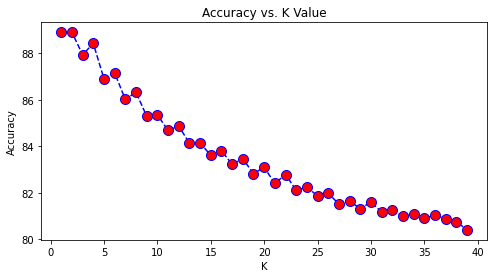

In [107]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

acc_list = []
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    accuracy_scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    acc_knn = round(accuracy_scores.mean()*100, 2)
#     acc_knn = evaluate_model(knn, X_train, y_train)
    acc_list.append(acc_knn)
    
plt.figure(figsize=(8,4))
plt.plot(range(1,40),acc_list,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [108]:
k_max_list = [i for i in acc_list]
k_max = acc_list.index(max(k_max_list))+1
print(k_max)

2


In [109]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', leaf_size=5, weights='uniform', p=2)

# params = {
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
# #     'leaf_size': [5, 10, 15, 20, 25, 30, 35],
# #     'weights': ['uniform', 'distance'],
# #     'p': [1, 2, 3, 4, 5, 6],
#          }
# clf_knn = GridSearchCV(estimator=knn, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_knn.best_params_)
# acc_knn = clf_knn.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_knn))

CPU times: user 19 µs, sys: 175 µs, total: 194 µs
Wall time: 196 µs


In [110]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(knn, X_train, y_train, X_test, y_test)
model_results['knn'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')
# print(model_results)

Accuracy: 87.9%
KFold Accuracy Mean: 86.91%
Standard Deviation: 0.83
ROC Score: 87.9%
Precision: 82.76%
Recall: 95.72%
F1 Score: 88.77%
===
CPU times: user 1.14 s, sys: 656 ms, total: 1.8 s
Wall time: 1.42 s


<div class="alert alert-block alert-success">
    <h4>
        Stochastic Gradient Descent
    </h4>
</div>

<img src="https://miro.medium.com/max/1005/1*f0CuPDSWFUr9XGESWQ4JUA.png" style="height:200px">

In [111]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(loss='log', penalty='l1', alpha=0.0002, learning_rate='adaptive', 
                     eta0=0.03, power_t=0.7, validation_fraction=0.07, n_iter_no_change=1)

# params = {
# #     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
# #              'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
# #     'penalty': ['l1', 'l2', 'elasticnet'],
# #     'alpha': [i for i in np.arange(0.0001, 0.001, 1/10000)],
# #     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
# #     'eta0': [0.01, 0.03, 0.05, 0.07],
# #     'power_t': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
# #     'validation_fraction': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
# #     'n_iter_no_change': [1, 3, 5, 7, 9, 11],
#          }
# clf_sgdc = GridSearchCV(estimator=sgdc, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_sgdc.best_params_)
# acc_sgdc = clf_sgdc.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_sgdc))

CPU times: user 37 µs, sys: 78 µs, total: 115 µs
Wall time: 117 µs


In [112]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(sgdc, X_train, y_train, X_test, y_test)
model_results['sgdc'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')
# print(model_results)

Accuracy: 85.98%
KFold Accuracy Mean: 85.84%
Standard Deviation: 0.76
ROC Score: 85.98%
Precision: 87.88%
Recall: 83.46%
F1 Score: 85.61%
===
CPU times: user 181 ms, sys: 160 ms, total: 341 ms
Wall time: 347 ms


<div class="alert alert-block alert-success">
    <h4>
        Gradient Boosting Trees
    </h4>
</div>

<img src="https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png" style="height:200px">

In [113]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.2, n_estimators=120, criterion='mse',
                                max_depth=2, subsample=0.9)

# params = {
# #         'loss': ['deviance', 'exponential'],
# #     'learning_rate': [0.05, 0.1, 0.2, 0.25, 0.3, 0.35],
# #     'n_estimators': [20,40,80,100,120],
# #     'subsample':[0.9,0.95,1,1.1],
#     'criterion': ['friedman_mse', 'mse', 'mae'],
# #     'max_depth': [1,2,3,4,6,8],
#          }
# clf_gbc = GridSearchCV(estimator=gbc, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_gbc.best_params_)
# acc_gbc = clf_gbc.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_gbc))

CPU times: user 28 µs, sys: 97 µs, total: 125 µs
Wall time: 127 µs


In [114]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(gbc, X_train, y_train, X_test, y_test)
model_results['gbc'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')
# print(model_results)

Accuracy: 88.37%
KFold Accuracy Mean: 87.16%
Standard Deviation: 0.63
ROC Score: 88.37%
Precision: 89.25%
Recall: 87.23%
F1 Score: 88.23%
===
CPU times: user 1.16 s, sys: 12.9 ms, total: 1.17 s
Wall time: 4.01 s


<div class="alert alert-block alert-success">
    <h4>
        xgboost -> XGBClassifier
    </h4>
</div>

In [115]:
%%time
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(booster='gbtree', eval_metric='logloss', sketch_eps=0.0, eta=0.07, max_depth=4, 
                min_child_weight=2.8, n_estimators=80, max_delta_step=2, subsample=1, use_label_encoder=False)

# params = {
# #     'sketch_eps': [i for i in np.arange(0, 0.1, 1/100)],
# #     'eta': [0.01,0.03,0.05,0.07,0.09],
# #     'max_depth': [4,6,8,10,12],
# #     'n_estimators': [20,40,80,120],
# #     'min_child_weight' : [2.5,2.6,2.7,2.8,2.9,3],
# #     'max_delta_step':[1,1.5,2],
# #     'subsample':[0.9,0.95,1]
#          }
# clf_xgb = GridSearchCV(estimator=xgb, cv=5, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train, y_train)
# print('best prarams:', clf_xgb.best_params_)
# acc_xgb = clf_xgb.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_xgb))

CPU times: user 19.8 ms, sys: 12.4 ms, total: 32.2 ms
Wall time: 44.9 ms


In [116]:
%%time
(accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, 
 f1) = evaluate_model(xgb, X_train, y_train, X_test, y_test)
model_results['xgb'] = [accuracy, kFold_accuracy_mean, kFold_accuracy_std, roc, precision, recall, f1]
print('===')
# print(model_results)

Accuracy: 88.27%
KFold Accuracy Mean: 86.96%
Standard Deviation: 0.49
ROC Score: 88.27%
Precision: 89.18%
Recall: 87.11%
F1 Score: 88.13%
===
CPU times: user 669 ms, sys: 11.3 ms, total: 681 ms
Wall time: 2.5 s


<a id='4.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Model selection - final
   </h3>
</div>

In [117]:
df_models_acc = pd.DataFrame(model_results, index=['accuracy', 'kFold_acc_mean', 'kFold_acc_std', 
                                                   'roc', 'precision', 'recall', 'f1']).T
df_models_acc.sort_values(by='accuracy', ascending=False)

,accuracy,kFold_acc_mean,kFold_acc_std,roc,precision,recall,f1
rf,90.07,88.91,0.73,90.07,90.27,89.81,90.04
gbc,88.37,87.16,0.63,88.37,89.25,87.23,88.23
xgb,88.27,86.96,0.49,88.27,89.18,87.11,88.13
svm,87.93,87.61,0.76,87.93,91.53,83.58,87.38
knn,87.90,86.91,0.83,87.90,82.76,95.72,88.77
log,86.42,85.91,0.63,86.42,89.07,83.02,85.94
sgdc,85.98,85.84,0.76,85.98,87.88,83.46,85.61
bNB,76.74,76.44,0.94,76.74,75.30,79.56,77.37


<a id='4.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Evaluation of the selected model
   </h3>
</div>

In [129]:
model = rf

<div class="alert alert-block alert-success">
    <h4>
        Confusion matrix and metrics
    </h4>
</div>

In [123]:
import math

def confusion_matrix_metrics(TP, FP, FN, TN):
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = round((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = round(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = round(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = round(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = round((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = round(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = round(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = round(FN / (FN + TP), 2)
    
    return TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR

In [124]:
def TP_FP_TN_FN_func(cm, dataframe):
    df_cm = pd.DataFrame(cm)
    TP = []
    FN = []
    TN = []
    FP = []
    for i in range(len(df_cm)):
        for j in range(len(df_cm.columns)):
            if i == j:
                # TP
                TP.append(df_cm.iloc[i,j])
                # FN
                df_FN = df_cm.drop(i, axis=0)
                FN_list = [row for row in range(len(df_cm)) if row != i]
                df_FN = df_FN.drop(FN_list, axis=1)
                FN.append(df_FN.sum().sum())
                # TN
                df_TN = df_cm.drop(i, axis=1)
                df_TN = df_TN.drop(i, axis=0)
                TN.append(df_TN.sum().sum())
                # FP
                df_FP = df_cm.drop(i, axis=1)
                FP_list = [row for row in range(len(df_cm)) if row != i]
                df_FP = df_FP.drop(FP_list, axis=0)
                FP.append(df_FP.sum().sum())
                
    metrics_list = []
    for i in range(len(TP)):
        # get the metric values from the confusion_matrix_metrics function
        (TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, 
         F1, MCC, FPR, FNR) = confusion_matrix_metrics(TP[i], FP[i], FN[i], TN[i])
        metrics_list.append([TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR])
    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 'Precision', 
                  'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    
    # create a dataframe with multi-column
    l=[(dataframe, '0'),  (dataframe, '1')]
    df_cm_metrics = pd.DataFrame(metrics_list, columns=metrics_cols, index=l).T
    df_cm_metrics.columns = pd.MultiIndex.from_tuples(df_cm_metrics.columns, names=['Dataset','Metrics'])
    
    return df_cm_metrics

In [125]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_func(model, X_train, X_test, y_train, y_test, threshold):
    
    predicted_proba = model.predict_proba(X_train)
    y_train_pred = (predicted_proba [:,1] >= threshold).astype('int')
    predicted_proba_test = model.predict_proba(X_test)
    y_test_pred = (predicted_proba_test [:,1] >= threshold).astype('int')

    cm = confusion_matrix(y_train, y_train_pred).T
    cm_test = confusion_matrix(y_test, y_test_pred).T

    #############################
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the heatmap
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    # show all ticks
    axes[0].set_xticks(np.arange(len(cm.tolist())))
    axes[0].set_yticks(np.arange(len(cm.tolist())))
    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes[0].text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
    # Let the horizontal axes labeling appear on top.
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    axes[0].set_xlabel('Actual value', size=16)
    axes[0].set_ylabel('Predicted value', size=16)
    axes[0].set_title("Train", fontsize=20)
    
    # Plot the heatmap
    im = axes[1].imshow(cm_test, interpolation='nearest', cmap='Reds', aspect='auto')
    # show all ticks
    axes[1].set_xticks(np.arange(len(cm_test.tolist())))
    axes[1].set_yticks(np.arange(len(cm_test.tolist())))
    thresh = cm_test.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm_test.tolist())):
        for j in range(len(cm_test.tolist())):
            text = axes[1].text(j, i, cm_test.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
    # Let the horizontal axes labeling appear on top.
    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    axes[1].set_xlabel('Actual value', size=16)
    axes[1].set_title("Test", fontsize=20)

    fig.tight_layout()
    fig.show()
    
    # get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, 'Train')
    df_cm_test_metrics = TP_FP_TN_FN_func(cm_test, 'Test')
    
    return df_cm_metrics, df_cm_test_metrics

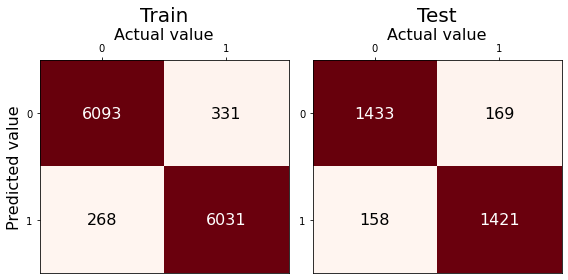

In [130]:
df_cm_metrics, df_cm_test_metrics = confusion_matrix_func(model, X_train, X_test, 
                                                          y_train, y_test, threshold=0.50)

In [131]:
pd.concat([df_cm_metrics, df_cm_test_metrics], axis=1)

Dataset                          Train        Test      
Metrics                              0     1     0     1
True Positive Rate                0.96  0.95  0.90  0.89
True Negative Rate                0.95  0.96  0.89  0.90
Accuracy                          0.95  0.95  0.90  0.90
Balanced Accuracy                 0.96  0.96  0.90  0.90
Precision                         0.95  0.96  0.89  0.90
Negative Predictive Value         0.96  0.95  0.90  0.89
False Discovery Rate              0.05  0.04  0.11  0.10
False Omission Rate               0.04  0.05  0.10  0.11
Prevalence Threshold              0.19  0.17  0.26  0.25
F1 Score                          0.95  0.95  0.90  0.90
Matthews Correlation Coefficient  0.91  0.91  0.79  0.79
False positive rate               0.05  0.04  0.11  0.10
False Negative Rate               0.04  0.05  0.10  0.11

<div class="alert alert-block alert-success">
    <h4>
        ROC & AUC
    </h4>
</div>

In [133]:
%%time
tpr_list = []
tnr_list = []
fpr_list = []
acc_list = []
thresholds_list = []
precision_list = []
npv_list = []

for i in range(0, 1000, 1):
    y_test_prob = model.predict_proba(X_test)
    y_test_pred = (y_test_prob [:,1] >= i/1000).astype('int')
    cm_test = confusion_matrix(y_test, y_test_pred).T
    df_cm_test_metrics = TP_FP_TN_FN_func(cm_test, 'Test')
    TPR_test = df_cm_test_metrics.loc['True Positive Rate','Test'][0]
    TNR_test = df_cm_test_metrics.loc['True Negative Rate','Test'][0]
    FPR_test = df_cm_test_metrics.loc['False positive rate','Test'][0]
    acc_test = df_cm_test_metrics.loc['Accuracy','Test'][0]
    precision_test = df_cm_test_metrics.loc['Precision','Test'][0]
    npv_test = df_cm_test_metrics.loc['Negative Predictive Value','Test'][0]
    
    tpr_list.append(TPR_test)
    tnr_list.append(TNR_test)
    fpr_list.append(FPR_test)
    acc_list.append(acc_test)
    thresholds_list.append(i/1000)
    precision_list.append(precision_test)
    npv_list.append(npv_test)

CPU times: user 47 s, sys: 174 ms, total: 47.2 s
Wall time: 47.2 s


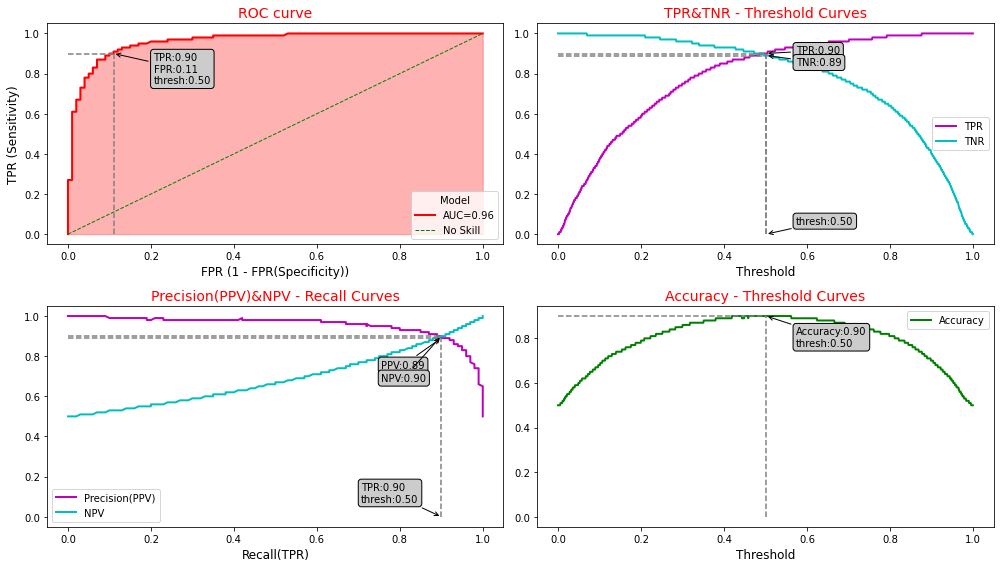

In [136]:
from sklearn.metrics import roc_auc_score

threshold=0.50
idx = next(x[0] for x in enumerate(thresholds_list) if x[1] > threshold)
pred_proba_test = model.predict_proba(X_test)

# compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
lr_auc = roc_auc_score(y_test, pred_proba_test[:, 1])

#############################
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#############################
### ROC Curve ###

axes[0, 0].plot(fpr_list, tpr_list, color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(fpr_list, tpr_list, 0, color='red', alpha=0.3)
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

axes[0, 0].set_xlabel('FPR (1 - FPR(Specificity))', size=12)
axes[0, 0].set_ylabel('TPR (Sensitivity)', size=12)
axes[0, 0].legend(title='Model')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# Annotate #
axes[0, 0].plot([0,fpr_list[idx]], [tpr_list[idx],tpr_list[idx]], 'k--', color='gray')
axes[0, 0].plot([fpr_list[idx],fpr_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 0].annotate(
    f'TPR:{tpr_list[idx]:.2f}\nFPR:{fpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (fpr_list[idx], tpr_list[idx]), xytext =(-2 * -20, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### TPR and FPR at every threshold ###

axes[0, 1].plot(thresholds_list, tpr_list, color='m', linewidth=2, label='TPR')
axes[0, 1].plot(thresholds_list, tnr_list, color='c', linewidth=2, label='TNR')
axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR&TNR - Threshold Curves', color='red', size=14)

axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')


# Annotate #
axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tpr_list[idx] ,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tnr_list[idx] ,tnr_list[idx]], 'k--', color='gray')

axes[0, 1].annotate(
    f'TPR:{tpr_list[idx]:.2f}',
    (thresholds_list[idx], tpr_list[idx]), xytext =(-2 * -15, 0), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(
    f'TNR:{tnr_list[idx]:.2f}',
    (thresholds_list[idx], tnr_list[idx]), xytext =(-2 * -15, -10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(f'thresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], 0), xytext =(-2 * -15, 10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Precision-Recall Curve ###

axes[1, 0].plot(tpr_list, precision_list, color='m', linewidth=2, label='Precision(PPV)')
axes[1, 0].plot(tpr_list, npv_list, color='c', linewidth=2, label='NPV')

axes[1, 0].set_xlabel('Recall(TPR)', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision(PPV)&NPV - Recall Curves', color='red', size=14)

# Annotate
axes[1, 0].plot([tpr_list[idx],tpr_list[idx]], [0,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [precision_list[idx] ,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [npv_list[idx] ,npv_list[idx]], 'k--', color='gray')

axes[1, 0].annotate(f'PPV:{precision_list[idx]:.2f}',
    (tpr_list[idx], precision_list[idx]), xytext =(-2 * 30, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'NPV:{npv_list[idx]:.2f}',
    (tpr_list[idx], npv_list[idx]), xytext =(-2 * 30, -45), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'TPR:{tpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (tpr_list[idx], 0), xytext =(-2 * 40, 15), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Accuracy at every threshold ###

axes[1, 1].plot(thresholds_list, acc_list, color='g', linewidth=2, label='Accuracy')
axes[1, 1].set_xlabel('Threshold', size=12)
axes[1, 1].legend()
axes[1, 1].set_title('Accuracy - Threshold Curves', color='red', size=14)

# Annotate #
axes[1, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,acc_list[idx]], 'k--', color='gray')
axes[1, 1].plot([0, thresholds_list[idx]], [acc_list[idx] ,acc_list[idx]], 'k--', color='gray')

axes[1, 1].annotate(
    f'Accuracy:{acc_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], acc_list[idx]), xytext =(-2 * -15, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

#############################
fig.tight_layout()
fig.show()

<div class="alert alert-block alert-success">
    <h4>
        Logarithmic loss
    </h4>
</div>

- A lower log loss, a higher model success, means better predictions

In [137]:
from sklearn.metrics import log_loss
# Running Log loss on training
print('The Log Loss on Training is: {:.2}'.format(log_loss(y_test, pred_proba_test[:, 1])))

The Log Loss on Training is: 0.29
